In [1]:
using Oceananigans
using CairoMakie
using Statistics
include("src-fronts/parameters.jl")
include("src-fronts/base_state.jl")
include("src-fronts/grid_cells.jl")
include("src-fig/plotting.jl")

foldername = "../scratch/Project/Strain"

"../scratch/Project/Strain"

# Explanatory Notebook: Fronts in a strain flow

In [2]:
iterations, times = iterations_times(foldername)
sp = simulation_parameters(foldername)
xsᶜ, xsᶠ, ysᶜ, ysᶠ, zsᶜ, zsᶠ = grid_nodes(foldername)
inds = centre_indices(foldername);

## Initial conditions
The mixed layer front is achieved by tilting the isopycnals of a vertically mixed front

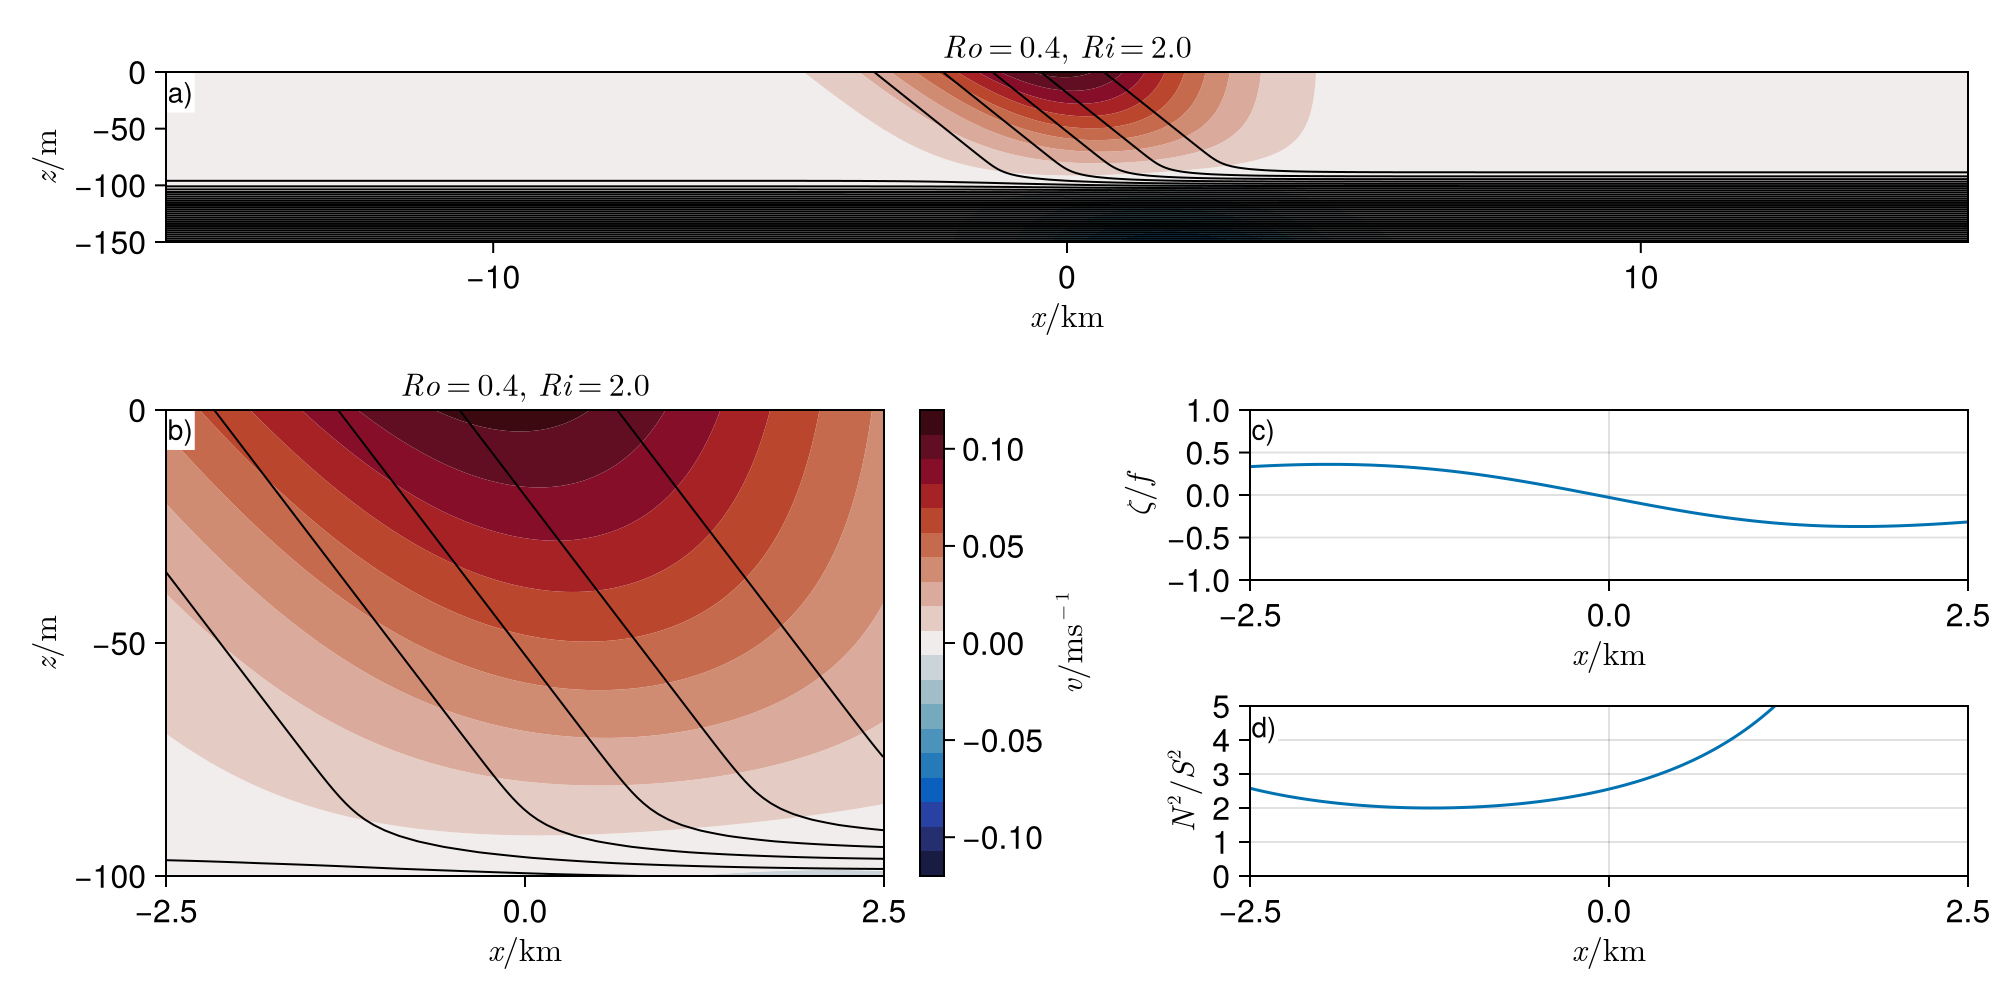

In [15]:
fig = Figure(; 
    size=(1000, 500),
    fontsize=16
)

v_levels = range(-0.12, 0.12, 20)
b_levels = range(-0.01, -0.004, 60)

initial_b(x, z) = front_buoyancy(1000x, z, sp)
initial_v(x, z) = approximate_front_velocity(1000x, z, sp)

# Whole domain
ax = Axis(fig[1, 1:3];
    xlabel=L"x / \text{km}", 
    ylabel=L"z / \text{m}", 
    title=L"$Ro = %$(sp.Ro)$, $Ri = %$(sp.Ri)$", 
    limits=(-sp.Lx/2000, sp.Lx/2000, -sp.Lz, 0),
)

ct = contourf!(ax, xsᶠ ./ 1000, zsᶠ, initial_v; levels=v_levels, colormap=:balance)
contour!(ax, xsᶠ ./ 1000, zsᶠ, initial_b; levels=b_levels, color=:black)

# Zoomed-in

ax = Axis(fig[2:3, 1];
    xlabel=L"x / \text{km}", 
    ylabel=L"z / \text{m}", 
    title=L"$Ro = %$(sp.Ro)$, $Ri = %$(sp.Ri)$", 
    limits=(-sp.ℓ/1000, sp.ℓ/1000, -sp.H, 0)
)


ct = contourf!(ax, xsᶠ ./ 1000, zsᶠ, initial_v; levels=v_levels, colormap=:balance)
contour!(ax, xsᶠ ./ 1000, zsᶠ, initial_b; levels=b_levels, color=:black)

Colorbar(fig[2:3, 2], ct; label=L"v / \text{ms}^{-1}")

ax = Axis(fig[2, 3];
    xlabel=L"x / \text{km}", 
    ylabel=L"\zeta / f",
    limits=(-sp.ℓ/1000, sp.ℓ/1000, -1, 1)
)
initial_surface_ζ(x) = approximate_front_vorticity(1000x, 0, sp) / sp.f
lines!(ax, xsᶠ ./ 1000, initial_surface_ζ)

ax = Axis(fig[3, 3];
    xlabel=L"x / \text{km}", 
    ylabel=L"N^2 / S^2",
    limits=(-sp.ℓ/1000, sp.ℓ/1000, 0, 5)
)

initial_surface_Ri(x) = front_Ri(1000x, 0, sp)
lines!(ax, xsᶠ ./ 1000, initial_surface_Ri)

subfig_label!(fig[1, :], 1)
subfig_label!(fig[2:3, 1], 2)
subfig_label!(fig[2, 3], 3)
subfig_label!(fig[3, 3], 4)

fig

## Stretched grid
In order allow the front to cross a range of scales, we vary the resolution in the across-front direction. The spacing is uniform in a high-resolution central region, and expands exponentially away from it. 

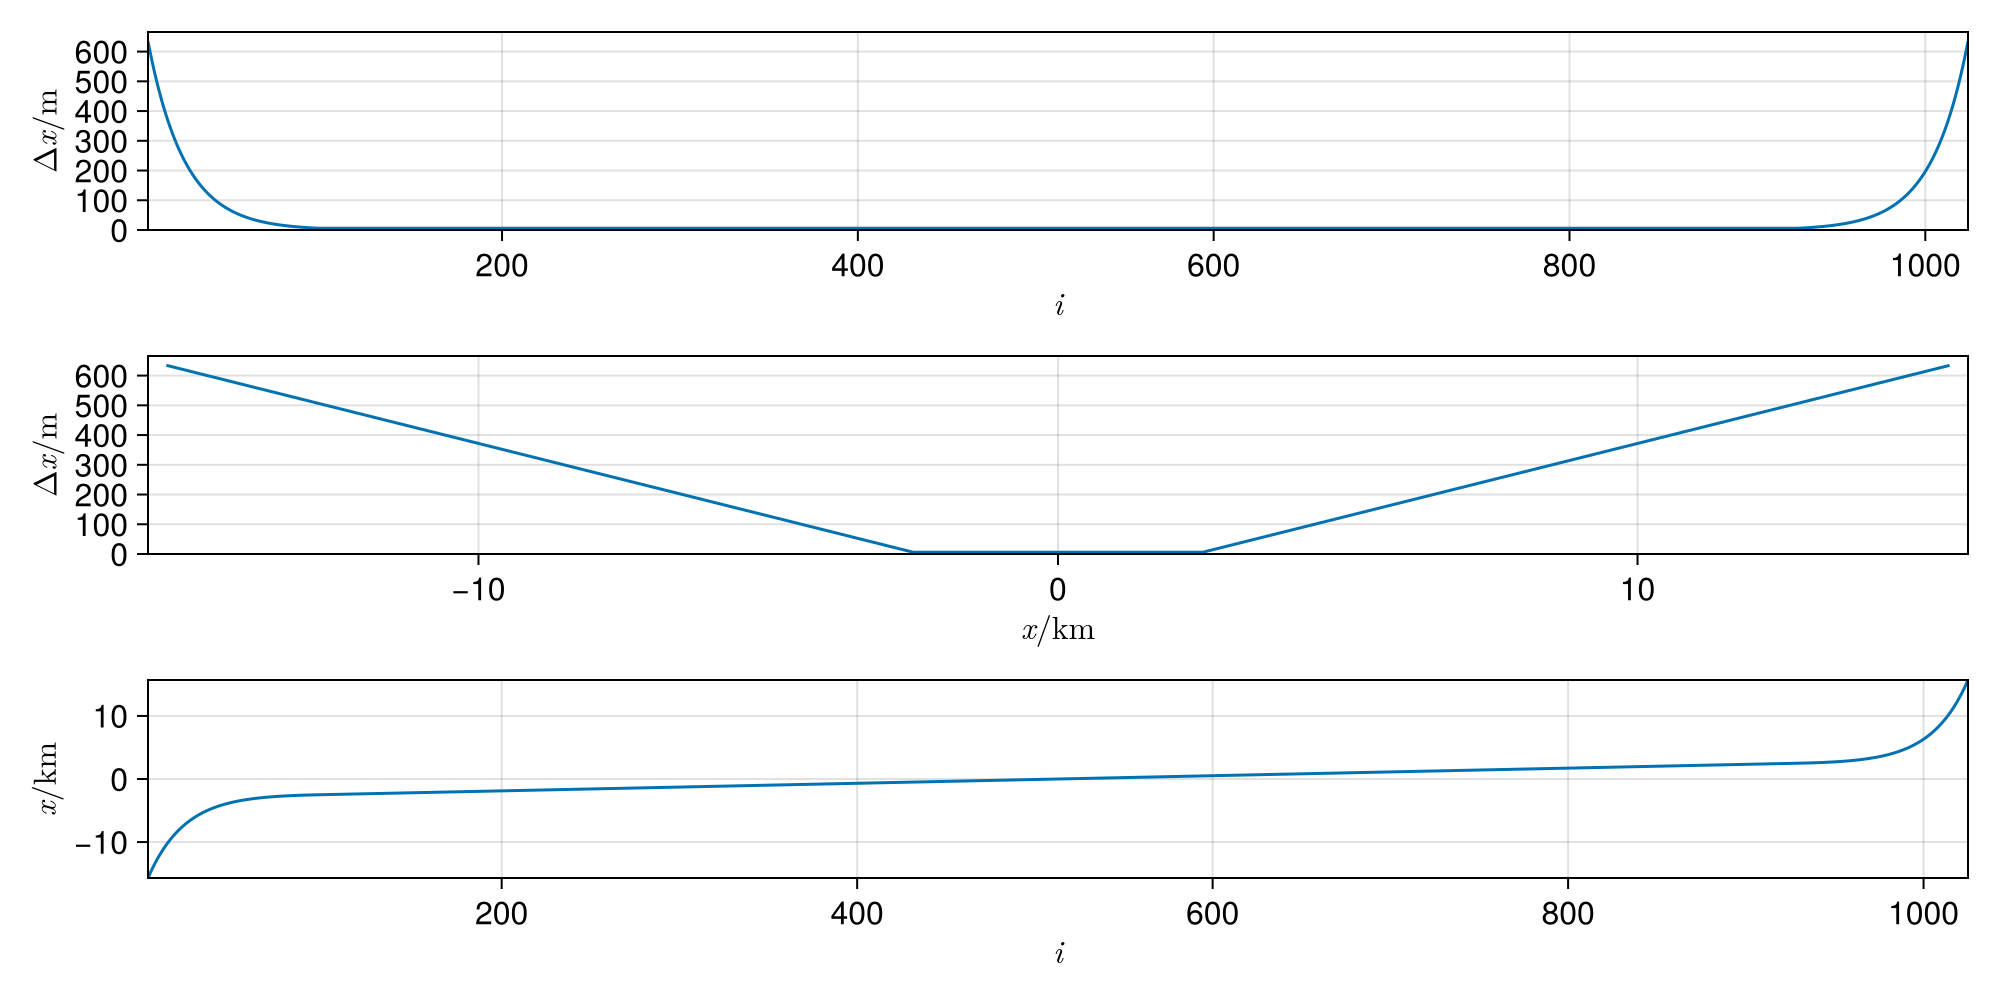

In [25]:
fig = Figure(; 
    size=(1000, 500),
    fontsize=16
)

# Grid spacing as a function of position and index
ax = Axis(fig[1, 1];
    xlabel=L"i",
    ylabel=L"\Delta x / \text{m}",
    limits=(1, sp.Nx, 0, nothing),
)

lines!(ax, 1:sp.Nx, diff(xsᶠ))

ax = Axis(fig[2, 1];
    xlabel=L"x / \text{km}",
    ylabel=L"\Delta x / \text{m}",
    limits=(-sp.Lx/2000, sp.Lx/2000, 0, nothing),
)

lines!(ax, xsᶜ / 1000, diff(xsᶠ))

ax = Axis(fig[3, 1];
    xlabel=L"i",
    ylabel=L"x / \text{km}",
    limits=(1, sp.Nx+1, -sp.Lx/2000, sp.Lx/2000),
)

lines!(ax, xsᶠ/1000)

fig

## Forcing
The strain forcing is applied across the whole domain. We are interested in perturbations about a long front. That is, we are simulating $\mathbf{u}$ where

$$
\frac{D}{Dt}(\mathbf{u} + \mathbf{U}) + f\hat{\mathbf{z}} \times \mathbf{u} + \nabla p = b\hat{\mathbf{z}},
$$

$$
\frac{D}{Dt} = \frac{\partial }{\partial t} + (\mathbf{u} + \mathbf{U}) \cdot \nabla, \text{ and } \mathbf{U} = \begin{pmatrix}-\alpha x \\ \alpha y \\ 0\end{pmatrix}
$$

The boundary conditions are, for a general field $\phi$

$$
\begin{array}{cc}
x = \pm L_x/2 & u = v_x = w_x = b_x = 0 \\
y = \pm L_y/2 & \phi(x, L_y/2, z) = \phi(x, -L_y/2, z)\\
    z = 0 & u_z = v_z = w = 0 \\
          & b\!: \text{flux } Q 
\end{array}
$$

In the $y$ direction, we use periodic boundary conditions in Oceananigans. By default, applying an `AdvectiveForcing` in continuous (or discrete!) form (e.g. `U(x, y, z) = -α * x` and `V(x, y, z) = α * y`) will make the forcing function satisfy the periodic boundary conditions in $y$, which we do not want. We amend this by altering the fields directly.

```julia
@inline function calculate_UV_callback(simulation, sp)
    t = simulation.model.clock.time
    α = variable_strain_rate(t, sp.α, sp.f)
    
    # Need to bypass periodic halo
    U.data.parent .= -α * Xs.data.parent
    V.data.parent .= α * Ys.data.parent
    
    return nothing
end
```

## Plug-in estimation of implicit diffusion

We compute advection terms with a ninth-order WENO advection scheme. For one dimensional advection of a tracer $\psi$, this finite difference scheme can be shown to converge to a modified advection-dissipation equation more rapidly than the unmodified equation:
$$
\frac{D\psi}{Dt} =  a(\Delta x)^{10}\frac{\partial^{10} \psi}{\partial x^{10}},
$$
where $\Delta x$ is the grid spacing and $a$ is $O(1)$ (but may depend on location). The term on the right hand side acts to remove spatial gradients in $\psi$.
